Vamos a ver el ejemplo con el [dataset de Iris](https://es.wikipedia.org/wiki/Conjunto_de_datos_flor_iris).

Aunque los GMM se utilizan para la agrupación en clústeres, podemos comparar los clústeres obtenidos con las clases reales del conjunto de datos de Iris porque los datos están etiquetados. Inicializamos las medias del GMM con las medias de cada grupo teniendo en cuenta las clases del conjunto de entrenamiento para que esta comparación sea válida.

En las gráficas, los datos de entrenamiento se muestran como puntos, mientras que los datos de prueba se muestran como cruces. El conjunto de datos del iris es de cuatro dimensiones (4 variables). En los gráficos solo se muestran las dos primeras dimensiones y, por lo tanto, algunos puntos de datos puede ser que estén separados en otras dimensiones.

Comparamos GMM con diferentes matrices de covarianza: esféricas (spherical), diagonales (diag), completas (full) y empatadas (tied).

* 'full' (los componentes pueden adoptar independientemente cualquier posición y forma)
* 'tied' (la matriz de covarianza tiene la misma forma, pero la forma puede ser cualquier cosa)
* 'diag' (cada componente tiene su propia matriz de covarianza diagonal)
* 'spherical' (cada componente tiene su propia varianza única)

Aunque uno esperaría que la covarianza completa funcione mejor en general, porque es más flexible, también por otro lado es propensa a sobreajustarse (overfitting) en conjuntos pequeños de datos y no generaliza bien a los datos de prueba.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

In [2]:
colors = ['navy', 'turquoise', 'darkorange']

In [3]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

In [4]:
iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing (25%) sets.
skf = StratifiedKFold(n_splits=4)

# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))

X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

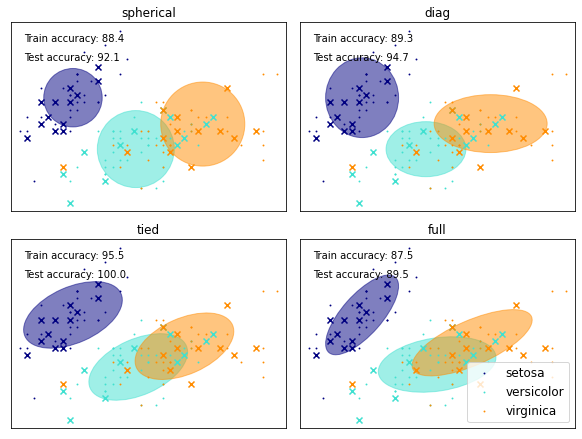

In [5]:
plt.figure(figsize=(4 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)


plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()